<a href="https://colab.research.google.com/github/Aidzillafont/crop_yield/blob/main/crop_yield.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
df = pd.read_csv('https://github.com/Aidzillafont/crop_yield/blob/9108554e8c4b815481fd7ec56d8912dfb3a219b8/yield_df.csv?raw=true', index_col=0)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28242 entries, 0 to 28241
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           28242 non-null  object 
 1   Item                           28242 non-null  object 
 2   Year                           28242 non-null  int64  
 3   hg/ha_yield                    28242 non-null  int64  
 4   average_rain_fall_mm_per_year  28242 non-null  float64
 5   pesticides_tonnes              28242 non-null  float64
 6   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.7+ MB


In [25]:
df.describe()

,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
count,28242.000000,28242.000000,28242.00000,28242.000000,28242.000000
mean,2001.544296,77053.332094,1149.05598,37076.909344,20.542627
std,7.051905,84956.612897,709.81215,59958.784665,6.312051
min,1990.000000,50.000000,51.00000,0.040000,1.300000
25%,1995.000000,19919.250000,593.00000,1702.000000,16.702500
50%,2001.000000,38295.000000,1083.00000,17529.440000,21.510000
75%,2008.000000,104676.750000,1668.00000,48687.880000,26.000000
max,2013.000000,501412.000000,3240.00000,367778.000000,30.650000


In [26]:
df['Area'].unique()

array(['Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Belarus', 'Belgium', 'Botswana', 'Brazil',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cameroon', 'Canada',
       'Central African Republic', 'Chile', 'Colombia', 'Croatia',
       'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Eritrea', 'Estonia', 'Finland', 'France', 'Germany', 'Ghana',
       'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras',
       'Hungary', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Italy',
       'Jamaica', 'Japan', 'Kazakhstan', 'Kenya', 'Latvia', 'Lebanon',
       'Lesotho', 'Libya', 'Lithuania', 'Madagascar', 'Malawi',
       'Malaysia', 'Mali', 'Mauritania', 'Mauritius', 'Mexico',
       'Montenegro', 'Morocco', 'Mozambique', 'Namibia', 'Nepal',
       'Netherlands', 'New Zealand', 'Nicaragua', 'Niger', 'Norway',
       'Pakistan', 'Papua New Guinea', 'Peru', 'Pola

In [27]:
df['Item'].unique()

array(['Maize', 'Potatoes', 'Rice, paddy', 'Sorghum', 'Soybeans', 'Wheat',
       'Cassava', 'Sweet potatoes', 'Plantains and others', 'Yams'],
      dtype=object)

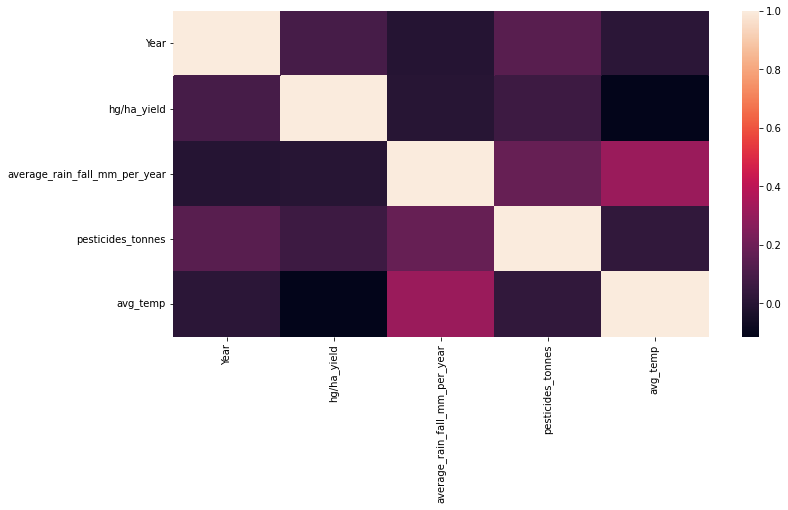

In [28]:
#Plot some correlations of numerical data
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr)
plt.show()

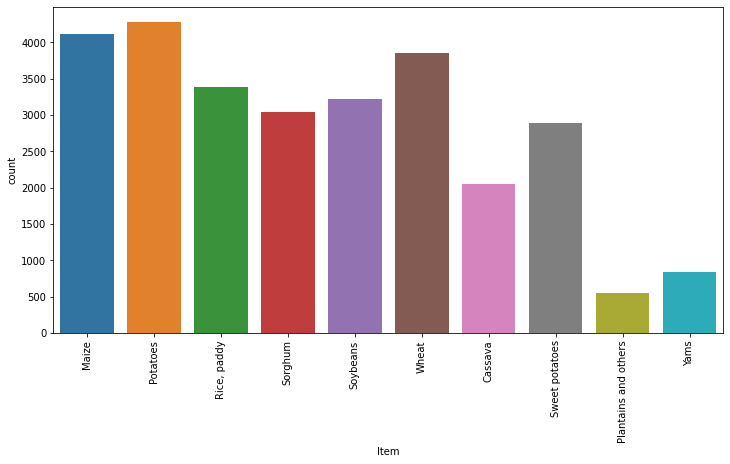

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

df_catagory = df.select_dtypes(include=['object'])
for col in df_catagory:
  if len(df_catagory[col].value_counts()) < 50:
    plt.figure(figsize=(12,6))
    sns.countplot(x=col, data=df)
    plt.xticks(rotation=90)

In [77]:
#train test splitter and grid search
from sklearn.model_selection import train_test_split, GridSearchCV

cata_feat = ['Area', 'Item']

numeric_feat = ['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']

label = ['hg/ha_yield']
features = numeric_feat + cata_feat
X = df[features]
y = df[label]

#split our test train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [78]:
#preprocess steps
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

#pipline 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

numeric_trans = Pipeline([ 
                          ('scaler', MinMaxScaler()), 
])

cata_trans = OneHotEncoder() 

#bundle our preprocessers together
preprocessor = ColumnTransformer([
                                  ('num', numeric_trans, numeric_feat),
                                  ('cat', cata_trans, cata_feat),
])


In [79]:
def run_model(model, preprocessor, param_grid):
  #pipleine it all together with a model
  pipe = Pipeline([
                    ('preprocess', preprocessor),
                    ('reg', model) 
  ])

  #fit the model
  cv = GridSearchCV( pipe, param_grid, n_jobs=-1, cv=5, verbose=10)
  cv.fit(X_train, y_train.values.ravel())
  return cv

In [116]:
#from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
param_grid = {#"reg__n_estimators": [100, 300],
              "reg__max_depth": [32, 64, 128],
              "reg__max_leaf_nodes": [254, 508, 1016]}

cv = run_model(DecisionTreeRegressor(), preprocessor, param_grid)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [117]:
cv.best_params_

{'reg__max_depth': 32, 'reg__max_leaf_nodes': 1016}

In [118]:
cv.best_score_

0.9605384802406836

In [119]:
cv.best_estimator_.score(X_test, y_test)

0.9634822125086236

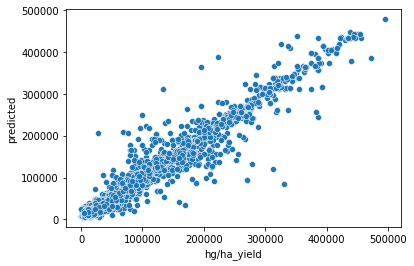

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

data_plt = y_test.copy()
data_plt['predicted'] = cv.best_estimator_.predict(X_test)
sns.scatterplot(x='hg/ha_yield', y='predicted', data=data_plt)